<a href="https://colab.research.google.com/github/Chuc-ngan/Low-Light-Image-Enhancement/blob/main/CreateDataLowLight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.18.0  # Thay đổi phiên bản theo nhu cầu

# **1. Kết nối với Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ColabNotebooks/TieuLuan'

!pwd

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1DnsWp1mopgehQJUYpN4ERfnj2CyapJGW/ColabNotebooks/TieuLuan
/content/gdrive/.shortcut-targets-by-id/1DnsWp1mopgehQJUYpN4ERfnj2CyapJGW/ColabNotebooks/TieuLuan


# **2. Import thư viện**

In [ ]:
# ===================== 1. Xử lý dữ liệu =====================
import os
import shutil  # Quản lý tệp/thư mục
import random
import math
import collections
import numpy as np  # Xử lý số học
import pandas as pd  # Xử lý dữ liệu CSV
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import pickle
# ===================== 2. Machine Learning =====================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

# ===================== 3. TensorFlow & Keras =====================
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ===================== 4. Xây dựng mô hình =====================
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,
    GlobalAveragePooling2D, Dense, Dropout, RepeatVector, Reshape, Flatten
)
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.layers import add, concatenate
from keras import layers, backend as K

# ===================== 5. Xử lý hình ảnh & Vẽ biểu đồ =====================
import cv2 as cv
import matplotlib.pyplot as plt

# ===================== 6. Đặt Seed (Reproducibility) =====================
tf.random.set_seed(42)  # Thay số 42 bằng giá trị seed mong muốn
np.random.seed(1)


# **3. Cấu hình môi trường TensorFlow**

In [ ]:
# Thiết lập GPU sử dụng bộ nhớ động (tránh lỗi thiếu bộ nhớ)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Kiểm tra TensorFlow đang chạy trên GPU hay không
print("TensorFlow is running on GPU:", tf.test.is_built_with_cuda())
# Bật chế độ Mixed Precision để tăng tốc (nếu GPU hỗ trợ)
# Thiết lập mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Bật XLA với cấu hình tối ưu
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({
    "layout_optimizer": True,
    "constant_folding": True,
    "shape_optimization": True,
    "remapping": True,
    "arithmetic_optimization": True,
    "dependency_optimization": True,
    "loop_optimization": True,
    "function_optimization": True,
    "debug_stripper": True
})

TensorFlow is running on GPU: True


# **4. Configuration**

In [ ]:
# Đường dẫn thư mục gốc
data_dir = "dataset/images"

# Thư mục đích
train_dir = "dataset/train"
val_dir = "dataset/validation"
test_dir = "dataset/test"

# Thư mục thiếu sáng
low_light_dir = "dataset/low_light"

low_light_noise_dir = "dataset/low_light_noise"

# Configuration
SPLIT_RATIO = 0.5  # Chỉ lấy 50%
IMG_SIZE = 224  # Slightly larger for more detail
CHANEL = 3
BATCH_SIZE = 32
EPOCHS = 3
VAL_SPLIT = 0.2
RANDOM_SEED = 42

# **5. Xử lý dữ liệu thô**

## **5.1 Xóa ảnh động**

In [ ]:
def find_and_delete_animated_images(directory):
    if not os.path.exists(directory):
        print(f"⚠️ Thư mục {directory} không tồn tại!")
        return

    for root, _, files in os.walk(directory):  # Duyệt qua từng thư mục con
        for img_name in files:
            img_path = os.path.join(root, img_name)
            try:
                with Image.open(img_path) as img:
                    # Kiểm tra ảnh động (n_frames > 1 hoặc is_animated)
                    if getattr(img, "is_animated", False) or (hasattr(img, "n_frames") and img.n_frames > 1):
                        os.remove(img_path)
                        print(f"🗑 Đã xóa ảnh động: {img_path}")
            except UnidentifiedImageError:
                continue  # Bỏ qua ảnh không hợp lệ
            except Exception as e:
                print(f"❌ Lỗi khi xử lý {img_path}: {e}")

# Xóa ảnh động trong thư mục dataset/images
print("\n🗑 **Bắt đầu xóa ảnh động...**")
find_and_delete_animated_images(data_dir)
print("\n✅ **Hoàn thành!**")


🗑 **Bắt đầu xóa ảnh động...**


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



✅ **Hoàn thành!**


## **5.2 Thống kê số lượng ảnh trong từng thư mục gốc**

In [ ]:
def count_images(directory):
    count_dict = {}
    if not os.path.exists(directory):
        print(f"⚠️ Thư mục {directory} không tồn tại!")
        return count_dict

    for root, dirs, files in os.walk(directory):  # Duyệt qua toàn bộ thư mục con
        if root != directory:  # Bỏ qua thư mục gốc
            category = os.path.basename(root)  # Lấy tên thư mục con
            count_dict[category] = len([img for img in files if os.path.isfile(os.path.join(root, img))])

    return count_dict

# Đếm ảnh trong thư mục dataset/images
print("\n📂 **Thống kê số lượng ảnh trong từng thư mục**")
counts = count_images(data_dir)

# Hiển thị kết quả
if counts:
    for category, count in counts.items():
        print(f"  📁 {category}: {count} ảnh")
else:
    print("⚠️ Không tìm thấy ảnh nào trong thư mục.")


📂 **Thống kê số lượng ảnh trong từng thư mục**
  📁 art and culture: 8535 ảnh
  📁 food and drinks: 8683 ảnh
  📁 architecture: 8661 ảnh
  📁 travel and adventure: 8800 ảnh


## **5.3 Chia dữ liệu**
```
   - Tập train 80%
   - Tập validation 10%
   - Tập test 10%
```




In [ ]:
# Định dạng ảnh hợp lệ
valid_extensions = {".jpg", ".jpeg", ".png"}

# Tạo thư mục nếu chưa tồn tại
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Tỷ lệ phân chia
test_ratio = 0.3    # 20%
val_ratio = 0.1     # 20%

# Duyệt qua từng thư mục con trong data/images
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)

    # Kiểm tra xem có phải thư mục không
    if not os.path.isdir(category_path):
        continue

    # Tạo thư mục con trong train, validation và test
    train_category_path = os.path.join(train_dir, category)
    val_category_path = os.path.join(val_dir, category)
    test_category_path = os.path.join(test_dir, category)

    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(val_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)

    # Lấy danh sách tất cả file ảnh hợp lệ
    images = [img for img in os.listdir(category_path)
              if os.path.isfile(os.path.join(category_path, img))
              and os.path.splitext(img)[1].lower() in valid_extensions]

    random.shuffle(images)  # Trộn ngẫu nhiên

    # Tính số lượng ảnh cho test, validation
    total_images = len(images)
    num_test = int(total_images * test_ratio)
    num_val = int(total_images * val_ratio)

    test_images = images[:num_test]  # 10%
    val_images = images[num_test:num_test + num_val]  # 20%
    train_images = images[num_test + num_val:]  # Phần còn lại

    # Copy ảnh vào thư mục test
    for img in test_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(test_category_path, img))

    # Copy ảnh vào thư mục validation
    for img in val_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(val_category_path, img))

    # Copy ảnh vào thư mục train
    for img in train_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(train_category_path, img))

print("✅ Chia dữ liệu hoàn tất!")

✅ Chia dữ liệu hoàn tất!


# **6. Tạo dữ liệu thiếu sáng**
```
  1. Nhiễu Gaussian
  Nhiễu Gaussian (nhiễu Gauss) là nhiễu ngẫu nhiên có phân bố chuẩn.
  Được sử dụng để mô phỏng nhiễu cảm biến trong máy ảnh.

  2. Nhiễu Salt & Pepper
  Gây ra các điểm ảnh trắng (Salt) và đen (Pepper) rải rác trong ảnh.
  Mô phỏng lỗi truyền dữ liệu hoặc lỗi cảm biến.

  3. Nhiễu Poisson
  Nhiễu Poisson (còn gọi là nhiễu Shot) xuất hiện do bản chất lượng tử của ánh sáng.
  Thường thấy trong điều kiện ánh sáng yếu hoặc khi ISO cao.

  4. Nhiễu Speckle
  Xuất hiện trong ảnh radar hoặc siêu âm, do sự phản xạ nhiễu loạn từ bề mặt gồ ghề.
  Gây ra các đốm sáng và tối ngẫu nhiên.
  ```

In [ ]:
def noisy(noise_type, image):
    if noise_type == "gauss":
        row, col, ch = image.shape
        mean = 0
        var = 20  # Giảm nhiễu xuống mức nhẹ hơn
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch)).astype(np.float32)
        noisy_img = image.astype(np.float32) + gauss
        return noisy_img

    elif noise_type == "s&p":
        noisy_img = np.copy(image)
        amount = 0.01  # Ít hơn để tránh hư ảnh
        s_vs_p = 0.5
        num_salt = np.ceil(amount * image.size * s_vs_p).astype(int)
        num_pepper = np.ceil(amount * image.size * (1.0 - s_vs_p)).astype(int)

        # Salt
        coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
        noisy_img[coords[0], coords[1], :] = 255

        # Pepper
        coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
        noisy_img[coords[0], coords[1], :] = 0

        return noisy_img

    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy_img = np.random.poisson(image.astype(np.float32) * vals) / float(vals)
        return noisy_img

    elif noise_type == "speckle":
        gauss = np.random.randn(*image.shape).astype(np.float32)
        noisy_img = image.astype(np.float32) + image.astype(np.float32) * gauss * 0.1
        return noisy_img

    else:
        return image

## **6.1 Tạo ảnh low-light kèm nhiễu ngẫu nhiên**

In [ ]:
def create_low_light_images(train_dir, low_light_dir):
    if not os.path.exists(low_light_dir):
        os.makedirs(low_light_dir)

    class_names = os.listdir(train_dir)

    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        low_light_class_dir = os.path.join(low_light_dir, class_name)
        os.makedirs(low_light_class_dir, exist_ok=True)

        image_paths = [
            os.path.join(class_dir, img_name)
            for img_name in os.listdir(class_dir)
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        for image_path in image_paths:
            img = cv.imread(image_path)
            if img is None:
                print(f"❌ Không thể đọc ảnh: {image_path}")
                continue

            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, (224, 224))

            # Làm tối ảnh
            hsv = cv.cvtColor(img_resized, cv.COLOR_RGB2HSV).astype(np.float32)
            # Làm tối ảnh mạnh hơn
            dark_factor = random.uniform(0.2, 0.5)
            hsv[..., 2] *= dark_factor
            hsv = np.clip(hsv, 0, 255).astype(np.uint8)
            img_dark = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

            # Thử thêm nhiễu
            noise_type = random.choice(["gauss", "s&p", "poisson", "speckle"])
            try:
                img_noisy = noisy(noise_type, img_dark)
                img_noisy = np.clip(img_noisy, 0, 255).astype(np.uint8)
                final_image = img_noisy
            except Exception as e:
                print(f"⚠️ Lỗi khi thêm nhiễu {noise_type} cho ảnh {image_path}: {e}")
                # Nếu lỗi thì giữ nguyên ảnh đã làm tối
                final_image = img_dark

            # Lưu ảnh
            img_name = os.path.basename(image_path)
            save_path = os.path.join(low_light_class_dir, img_name)
            cv.imwrite(save_path, cv.cvtColor(final_image, cv.COLOR_RGB2BGR))

In [ ]:
# Gọi hàm để tạo ảnh low light
create_low_light_images(test_dir, low_light_noise_dir)

## **6.2 Tạo ảnh low-light**

In [ ]:
# Hàm tạo ảnh chỉ bị thiếu sáng (không có nhiễu)
def create_dark_only_images(train_dir, low_light_only_dir):
    if not os.path.exists(low_light_only_dir):
        os.makedirs(low_light_only_dir)

    class_names = os.listdir(train_dir)

    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        dark_class_dir = os.path.join(low_light_only_dir, class_name)

        os.makedirs(dark_class_dir, exist_ok=True)

        image_paths = [
            os.path.join(class_dir, img_name)
            for img_name in os.listdir(class_dir)
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        for image_path in image_paths:
            img = cv.imread(image_path)
            if img is None:
                print(f"❌ Không thể đọc ảnh: {image_path}")
                continue

            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, (224, 224))

            # Làm tối ảnh
            hsv = cv.cvtColor(img_resized, cv.COLOR_RGB2HSV)
            dark_factor = random.uniform(0.1, 0.5)  # Ngẫu nhiên độ tối từ 10% đến 50%
            hsv[..., 2] = hsv[..., 2] * dark_factor

            img_dark = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

            # Lưu ảnh thiếu sáng
            img_name = os.path.basename(image_path)
            save_path = os.path.join(dark_class_dir, img_name)
            cv.imwrite(save_path, cv.cvtColor(img_dark, cv.COLOR_RGB2BGR))

In [ ]:
# Gọi hàm để tạo ảnh thiếu sáng không nhiễu
create_dark_only_images(test_dir, low_light_dir)

# **7. Kiểm tra lại danh sách các ảnh trong từng tập dữ liệu**

In [ ]:
def count_images(directory):
    count_dict = {}
    if not os.path.exists(directory):
        print(f"⚠️ Thư mục {directory} không tồn tại!")
        return count_dict

    for root, dirs, files in os.walk(directory):
        if root != directory:
            category = os.path.basename(root)
            count_dict[category] = len([
                img for img in files if img.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
    return count_dict


# Danh sách thư mục cần thống kê
directories = {
    "Train": train_dir,
    "Validation": val_dir,
    "Test": test_dir,
    "Low Light": low_light_dir,
    "Low Light + Noise": low_light_noise_dir,
}

print("\n📊 **Thống kê số lượng ảnh trong các thư mục:**\n")

for label, path in directories.items():
    print(f"📁 {label}:")
    counts = count_images(path)
    if counts:
        for category, count in counts.items():
            print(f"   📌 {category}: {count} ảnh")
    else:
        print("   ⚠️ Không có ảnh hoặc thư mục không tồn tại.")


📊 **Thống kê số lượng ảnh trong các thư mục:**

📁 Train:
   📌 art and culture: 5122 ảnh
   📌 food and drinks: 5209 ảnh
   📌 architecture: 5197 ảnh
   📌 travel and adventure: 5280 ảnh
📁 Validation:
   📌 food and drinks: 868 ảnh
   📌 architecture: 866 ảnh
   📌 art and culture: 853 ảnh
   📌 travel and adventure: 880 ảnh
📁 Test:
   📌 food and drinks: 2604 ảnh
   📌 architecture: 2598 ảnh
   📌 art and culture: 2560 ảnh
   📌 travel and adventure: 2640 ảnh
📁 Low Light:
   📌 travel and adventure: 2640 ảnh
   📌 art and culture: 2560 ảnh
   📌 food and drinks: 2604 ảnh
   📌 architecture: 2598 ảnh
📁 Low Light + Noise:
   📌 art and culture: 2560 ảnh
   📌 food and drinks: 2604 ảnh
   📌 architecture: 2598 ảnh
   📌 travel and adventure: 2640 ảnh


# **8. Show image low light**

In [ ]:
def show_low_light_images(folder_path, num_images=9):
    if not os.path.exists(folder_path):
        print(f"⚠️ Thư mục {folder_path} không tồn tại!")
        return

    image_paths = []

    # Duyệt qua từng lớp và thu thập đường dẫn ảnh
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_paths.append(os.path.join(class_dir, img_name))

    if len(image_paths) == 0:
        print("⚠️ Không tìm thấy ảnh trong thư mục.")
        return

    # Lấy ngẫu nhiên num_images ảnh
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    # Hiển thị ảnh
    plt.figure(figsize=(12, 8))
    for i, img_path in enumerate(selected_images):
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

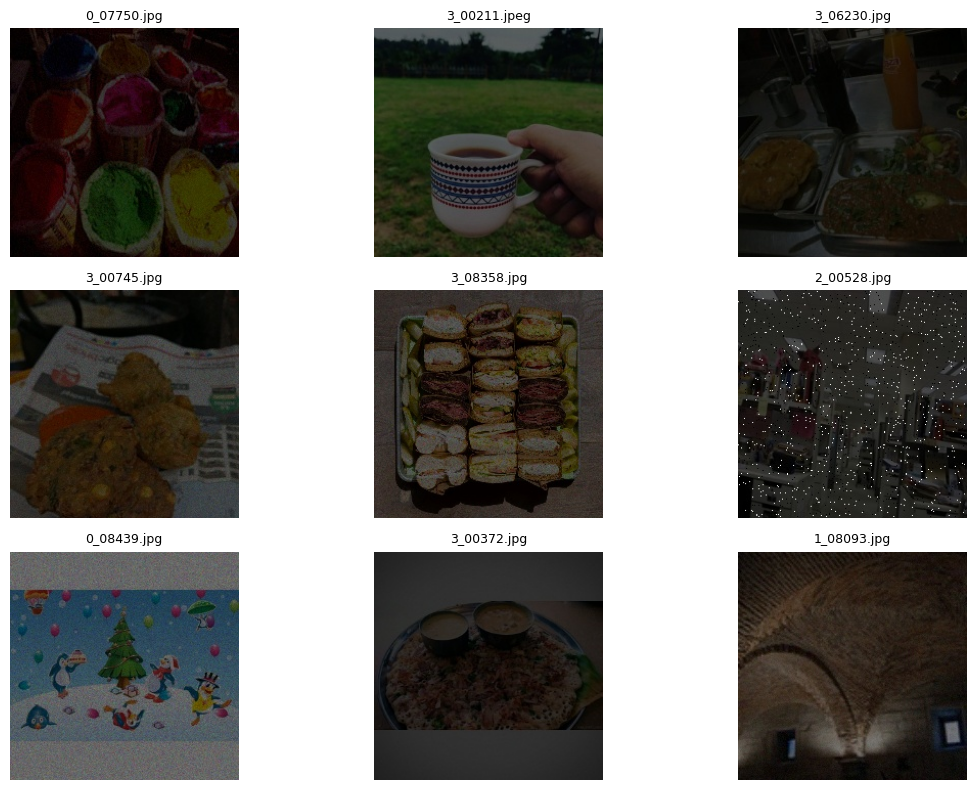

In [ ]:
show_low_light_images(low_light_noise_dir, num_images=9)